<a href="https://colab.research.google.com/github/steffenvogler/LLM2GPS/blob/main/LLM_Geocoding_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade --quiet geopy google-api-python-client google-cloud-aiplatform langchain-core google-generativeai langchain-google-genai

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Setting everything up

In [ ]:
import getpass
import math
import os
import pandas as pd
import pathlib
import textwrap

from google import genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate

# Used to securely store your API key
from google.colab import userdata

from IPython.display import display
from IPython.display import Markdown

from geopy.geocoders import Nominatim
from geopy import distance
geolocator = Nominatim(user_agent="LLM2GPS") # Many other geocoders available via GeoPy;  https://geopy.readthedocs.io/en/stable/#module-geopy.geocoders

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

## Enter access key for using Google LLMs

- visit https://aistudio.google.com/
- log-in with Google account
- bottom-left "Get API key"
- follow instructions for setup
- copy key to Colab "Secrets" tab

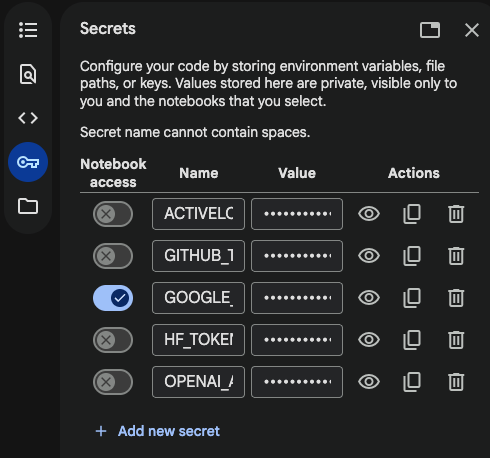

In [ ]:
api_key_from_secrets = userdata.get('GOOGLE_API_KEY')
print(f"API Key retrieved: {bool(api_key_from_secrets)}")
client = genai.Client(api_key=api_key_from_secrets)

## See which models are available

In [ ]:
response=client.models.list()
print(response.page)

## Selecting a model
Overview at https://console.cloud.google.com/vertex-ai/model-garden

In [ ]:
# LLM model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=api_key_from_secrets,
    max_output_tokens=256,
    temperature=0.8,
    top_p=0.8,
    top_k=5,
    verbose=True,
)

##Sanity Check

In [ ]:
result = llm.invoke("Tell a dad joke that contains the word dinosaur. Later provide German translation")
to_markdown(result.content)

## Build prompt to harmonize the location column

In [ ]:
template = """Your job is to guess the geographic loaction based on the description and keywords. Also fix typos and translate to English.
% USER input
{user_input}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_input"], template=template)

# Holds my 'location' chain
location_chain = prompt_template | llm

template = """Convert below input, into a structured output that looks like this:
"continent, country, city, name of the place or object"

Everything separated by a whitespace. Typos are fixed and translated to English. Only provide a single line of output. Never output any additional text. If there are more than one places that match the description or if you are not sure, add an asterisk sign ad the end of the response.
% USER geo
{user_geo}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_geo"], template=template)

# Holds my 'json' chain
geo_chain = prompt_template | llm

# Compose the chains directly using the '|' operator
overall_chain = location_chain | geo_chain

## Orchestrating the LLM query and responses

In [ ]:
def response_processing(location, i):
  if (location is None):
    #print (i)
    if i == 4:
      return
    #print("No location found")
    if i == 3:
      improved_query = query
    elif i == 2:
      improved_query = str(overall_chain.invoke(query))
    else:
      improved_query = str(overall_chain.invoke(query) + " " + query)
    location = geolocator.geocode(improved_query)
    i = i + 1
    response_processing(location,i)
  else:
    # try:
    #   print(improved_query)
    # except:
    #   print(query)
    print("GPS-coordinates: ({},{})".format(location.latitude, location.longitude))
    print("Address according to geocoding service: {}".format(location.address))
    xy0 = (location.raw['boundingbox'][0], location.raw['boundingbox'][2])
    xy1 = (location.raw['boundingbox'][1], location.raw['boundingbox'][3])
    print("Great circle distance in km: {}".format(round(distance.great_circle(xy0, xy1).km,2)))
    east_west_dist = haversine(location.raw['boundingbox'][0], location.raw['boundingbox'][2], location.raw['boundingbox'][0], location.raw['boundingbox'][3])
    north_south_dist = haversine(location.raw['boundingbox'][0], location.raw['boundingbox'][2], location.raw['boundingbox'][1], location.raw['boundingbox'][2])
    print("north_south_distance: {} and east-west-distance: {} (all in km)".format(north_south_dist, east_west_dist))

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
  """Calculates the great circle distance between two points on a sphere.

  Args:
    lat1: The latitude of the first point in degrees.
    lon1: The longitude of the first point in degrees.
    lat2: The latitude of the second point in degrees.
    lon2: The longitude of the second point in degrees.

  Returns:
    The great circle distance between the two points in kilometers.
  """

  R = 6371  # Earth's radius in kilometers

  dlat = math.radians(float(lat2) - float(lat1))
  dlon = math.radians(float(lon2) - float(lon1))
  a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(float(lat1))) * math.cos(math.radians(float(lat2))) * math.sin(dlon / 2) ** 2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
  d = R * c

  return d

In [ ]:
query = "Karibisches Meer, Grand Cayman" # @param ["Berlin", "Karibisches Meer, Grand Cayman", "Copenhagen Zoo", "Spreewald", "Gjoa Haven", "Mt. Cook", "Zugspitze", "Sandwich island", "the biggest city in the country where Kiwis live"] {allow-input: true}

In [ ]:
improved_query = str(overall_chain.invoke(query))

location = geolocator.geocode(improved_query)
print("original query: {}; LLM-improved query: {}".format(query,improved_query))

i = 0
response_processing(location, i)

## Now same concept used for enriching a public dataset
Download zip file from https://doi.org/10.15468/dl.6qs64w

In [ ]:
import requests, zipfile, io
zip_file_url = "https://occurrence-download.gbif.org/occurrence/download/request/0032930-231002084531237.zip"

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(zip_file_url,'sample_data/test.zip')
!unzip -o 'sample_data/test.zip'

In [ ]:
df = pd.read_csv("0032930-231002084531237.csv", sep='\t', low_memory=False)

In [ ]:
df.columns

In [ ]:
locality_list = list(df.locality.unique())

Assumption is that LLM can translate between human natural language and description that can be understood by Geocoding Service

In [ ]:
locality_list[:15]

## Fill in with GenAI coding assistant

Prompt:


Write a python function that loops over all rows in the table df. It uses overall_chain.invoke(query) to harmonise the query and then uses geolocator.geocode(improved_query) to get a location object. With location.latitude, location.longitude the GPS coordinates can be extracted. In the respective row at the value of location.latitude to a newly created column called lat_llm. Do the same for longitude value. Show progress of the loop via a progress bar. In this example only do this for the first 100 rows. Add a short delay between each call to avoid being blocked by the service.


